## Colin's active development sandbox

In [3]:
from enum import Enum
from pathlib import Path
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import re
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed
from DataPreProcessing import DataPreProcessing, DataPaths

### Tracklet iterator

[2025-02-26 10:54:04] - [INFO]: DataPreProcessing initialized.
[2025-02-26 10:54:04] - [INFO]: ROOT_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted
[2025-02-26 10:54:04] - [INFO]: TRAIN_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\train\images
[2025-02-26 10:54:04] - [INFO]: TEST_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\test\images
[2025-02-26 10:54:04] - [INFO]: VAL_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\challenge\images
[2025-02-26 10:54:04] - [INFO]: Using device: cuda
[2025-02-26 10:54:04] - [INFO]: ['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']
[2025-02-26 10:54:04] - [INFO]: Min tracklet: 0
[2025-02-26 10:54:04] - [INFO]: Max tracklet: 1426


Processing tracks:   0%|          | 0/1 [00:00<?, ?it/s]

[2025-02-26 10:54:12] - [INFO]: Track: 0, Loaded Tensor Shape: torch.Size([578, 3, 256, 256])
[2025-02-26 10:54:12] - [WARNING]: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.64].


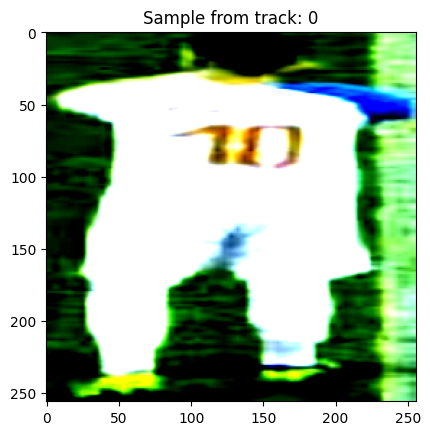

In [4]:
input_folder = DataPaths.TRAIN_DATA_DIR.value

# Instantiate the pre-processing class
data_pre = DataPreProcessing()

# Call generate_features with load_only=True to simply load the images as tensors
data_dict = data_pre.generate_features(input_folder, DataPaths.TEMP_EXPERIMENT_DIR.value, load_only=True, num_tracks=1)

# Inspect the loaded data
for track, tensor in data_dict.items():
    logging.info(f"Track: {track}, Loaded Tensor Shape: {tensor.shape}")

# Visualize a sample image from one track
import matplotlib.pyplot as plt
sample_track = list(data_dict.keys())[0]
sample_tensor = data_dict[sample_track][0]  # take the first image in the track
# Convert tensor to numpy and show it
plt.imshow(sample_tensor.permute(1, 2, 0).numpy())
plt.title(f"Sample from track: {sample_track}")
plt.show()